In [1]:
import torch
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import timm
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader, random_split
import torch.nn.functional as F
from torchvision import models

import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, confusion_matrix ,roc_curve
import seaborn as sns

In [2]:
chunk_size = 15

# List of Parquet file paths
file_paths = [
    '/kaggle/input/task2-24/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet',
    '/kaggle/input/task2-24/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet',
    '/kaggle/input/task2-24/QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet'
]

# Initialize an empty list to store dataframes
dfs = []

# Loop through each file path
for file_path in file_paths:
    # Create a Parquet file reader object
    parquet_file = pq.ParquetFile(file_path)
    
    # Determine the total number of rows in the file
    total_rows = parquet_file.metadata.num_rows
    
    # Calculate the number of chunks
    num_chunks = total_rows // chunk_size + (1 if total_rows % chunk_size else 0)
    
    # Loop over the file in chunks
    for chunk_index in range(num_chunks):
        # Read a chunk of rows from the file
        chunk = parquet_file.read_row_group(chunk_index, columns=None)
        df = chunk.to_pandas()
        
        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all the DataFrames into a single DataFrame
data = pd.concat(dfs, ignore_index=True)

In [3]:
def to_3d(arr):
    vishak=[]
    for i in range (0,3):
        vis=np.stack(np.stack(arr)[i],axis=-1)
        vishak.append(vis)
    vishak=np.array(vishak)
    return vishak

In [4]:
data["X_jets"]  = data["X_jets"].apply(to_3d)

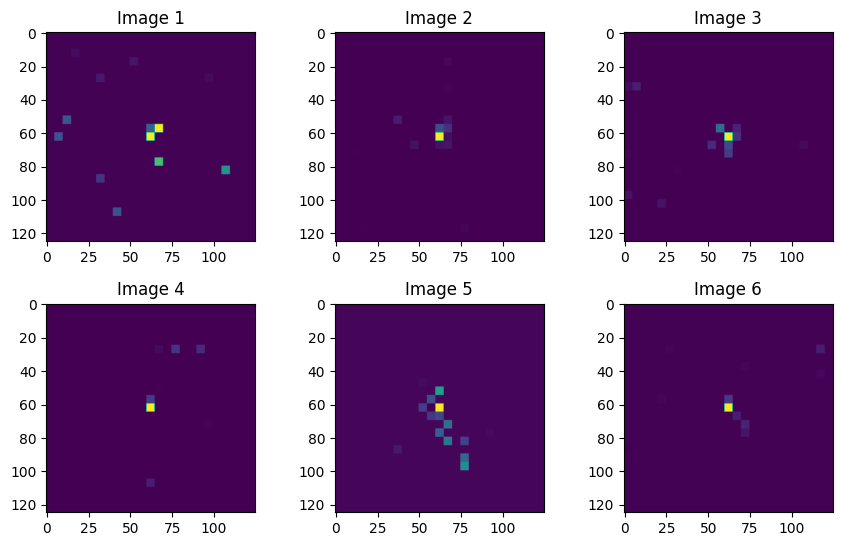

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Loop over the axes and image ids, and plot each image on a separate subplot
for i, ax in enumerate(axes.flatten()):
    image = data['X_jets'][i][2,:,:]
    ax.imshow(image)
    ax.set_title(f'Image {i+1}')
    
# Adjust spacing between subplots
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)

# Show the plot
plt.show()

In [6]:
data.columns

Index(['X_jets', 'pt', 'm0', 'y'], dtype='object')

In [7]:
# data['y']

In [8]:
class task2Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Assuming 'X_jets' column contains paths to images or actual image data
        X = self.dataframe.iloc[idx]['X_jets']
        mean = X.mean(axis=(0, 1, 2), keepdims=True)
        std = X.std(axis=(0, 1, 2), keepdims=True)

        # Normalize each channel separately
        X = (X - mean) / std
        y = self.dataframe.iloc[idx]['y']
        
        if self.transform:
            X = self.transform(X)
        
        # Convert X and y to PyTorch tensors
        X_tensor = torch.tensor(X, dtype=torch.float)
        y_tensor = torch.tensor(y, dtype=torch.long)

        return X_tensor, y_tensor


In [9]:
jet_dataset = task2Dataset(dataframe=data)


train_dataset, val_dataset = train_test_split(jet_dataset, test_size=0.2, random_state=42)


train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

In [10]:
next(iter(train_loader))[0].shape

torch.Size([256, 3, 125, 125])

In [11]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=2):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Adding dropout after pooling
        self.dropout1 = nn.Dropout(0.25)
        # Adjusted the size of the first fully connected layer according to your input size and architecture
        self.fc1 = nn.Linear(16 * 28 * 28, 120)
        # Adding dropout before the final fully connected layer
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = torch.flatten(x, 1)  # Flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet5(num_classes=2)
print(model)

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=12544, out_features=120, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [13]:
num_epochs = 20
train_losses, val_losses, val_accuracies = [], [], []
best_loss = 100000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train] Loss: 0.0000", leave=False)
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        train_bar.set_description(f"Epoch {epoch+1}/{num_epochs} [Train] Loss: {loss.item():.4f}")
    
    #scheduler.step()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val] Loss: 0.0000, Acc: 0.0000", leave=True)
    
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            
            
            val_bar.set_description(f"Epoch {epoch+1}/{num_epochs} [Val] Loss: {loss.item():.4f}, Acc: {correct_predictions/total_predictions:.4f}")
    
    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    epoch_val_accuracy = correct_predictions / total_predictions
    best_loss = min(epoch_val_loss , best_loss)
    val_accuracies.append(epoch_val_accuracy)
    
    if(epoch_val_loss== best_loss):
        
            model_path = f"model_weights_{epoch}.pth"
            torch.save(model.state_dict(), model_path)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")


Epoch 1/20 [Val] Loss: 0.3360, Acc: 0.6529: 100%|██████████| 59/59 [00:00<00:00, 155.35it/s]


Epoch 1/20, Train Loss: 0.6557, Val Loss: 0.6303, Val Accuracy: 0.6529


Epoch 2/20 [Val] Loss: 0.2735, Acc: 0.6615: 100%|██████████| 59/59 [00:00<00:00, 226.69it/s]


Epoch 2/20, Train Loss: 0.6175, Val Loss: 0.6106, Val Accuracy: 0.6615


Epoch 3/20 [Val] Loss: 0.2299, Acc: 0.6787: 100%|██████████| 59/59 [00:00<00:00, 221.10it/s]


Epoch 3/20, Train Loss: 0.6056, Val Loss: 0.6019, Val Accuracy: 0.6787


Epoch 4/20 [Val] Loss: 0.2069, Acc: 0.6835: 100%|██████████| 59/59 [00:00<00:00, 184.50it/s]


Epoch 4/20, Train Loss: 0.5935, Val Loss: 0.5954, Val Accuracy: 0.6835


Epoch 5/20 [Val] Loss: 0.1995, Acc: 0.6895: 100%|██████████| 59/59 [00:00<00:00, 168.59it/s]


Epoch 5/20, Train Loss: 0.5833, Val Loss: 0.5887, Val Accuracy: 0.6895


Epoch 6/20 [Val] Loss: 0.1795, Acc: 0.6970: 100%|██████████| 59/59 [00:00<00:00, 212.64it/s]


Epoch 6/20, Train Loss: 0.5779, Val Loss: 0.5819, Val Accuracy: 0.6970


Epoch 7/20 [Val] Loss: 0.1755, Acc: 0.6975: 100%|██████████| 59/59 [00:00<00:00, 164.63it/s]


Epoch 7/20, Train Loss: 0.5632, Val Loss: 0.5828, Val Accuracy: 0.6975


Epoch 8/20 [Val] Loss: 0.1690, Acc: 0.7034: 100%|██████████| 59/59 [00:00<00:00, 212.92it/s]


Epoch 8/20, Train Loss: 0.5566, Val Loss: 0.5771, Val Accuracy: 0.7034


Epoch 9/20 [Val] Loss: 0.1599, Acc: 0.7061: 100%|██████████| 59/59 [00:00<00:00, 167.50it/s]


Epoch 9/20, Train Loss: 0.5529, Val Loss: 0.5763, Val Accuracy: 0.7061


Epoch 10/20 [Val] Loss: 0.1277, Acc: 0.7024: 100%|██████████| 59/59 [00:00<00:00, 217.81it/s]


Epoch 10/20, Train Loss: 0.5405, Val Loss: 0.5784, Val Accuracy: 0.7024


Epoch 11/20 [Val] Loss: 0.1422, Acc: 0.7072: 100%|██████████| 59/59 [00:00<00:00, 171.34it/s]


Epoch 11/20, Train Loss: 0.5379, Val Loss: 0.5758, Val Accuracy: 0.7072


Epoch 12/20 [Val] Loss: 0.1165, Acc: 0.7072: 100%|██████████| 59/59 [00:00<00:00, 161.58it/s]


Epoch 12/20, Train Loss: 0.5325, Val Loss: 0.5814, Val Accuracy: 0.7072


Epoch 13/20 [Val] Loss: 0.1268, Acc: 0.7094: 100%|██████████| 59/59 [00:00<00:00, 188.87it/s]


Epoch 13/20, Train Loss: 0.5276, Val Loss: 0.5769, Val Accuracy: 0.7094


Epoch 14/20 [Val] Loss: 0.1177, Acc: 0.7126: 100%|██████████| 59/59 [00:00<00:00, 168.70it/s]


Epoch 14/20, Train Loss: 0.5242, Val Loss: 0.5760, Val Accuracy: 0.7126


Epoch 15/20 [Val] Loss: 0.1242, Acc: 0.6927: 100%|██████████| 59/59 [00:00<00:00, 210.92it/s]


Epoch 15/20, Train Loss: 0.5165, Val Loss: 0.5904, Val Accuracy: 0.6927


Epoch 16/20 [Val] Loss: 0.1209, Acc: 0.7104: 100%|██████████| 59/59 [00:00<00:00, 174.77it/s]


Epoch 16/20, Train Loss: 0.5113, Val Loss: 0.5790, Val Accuracy: 0.7104


Epoch 17/20 [Val] Loss: 0.0938, Acc: 0.7088: 100%|██████████| 59/59 [00:00<00:00, 160.45it/s]


Epoch 17/20, Train Loss: 0.5035, Val Loss: 0.5875, Val Accuracy: 0.7088


Epoch 18/20 [Val] Loss: 0.1086, Acc: 0.6997: 100%|██████████| 59/59 [00:00<00:00, 220.18it/s]


Epoch 18/20, Train Loss: 0.4943, Val Loss: 0.5895, Val Accuracy: 0.6997


Epoch 19/20 [Val] Loss: 0.1023, Acc: 0.6943: 100%|██████████| 59/59 [00:00<00:00, 175.74it/s]


Epoch 19/20, Train Loss: 0.4857, Val Loss: 0.5913, Val Accuracy: 0.6943


Epoch 20/20 [Val] Loss: 0.1114, Acc: 0.7051: 100%|██████████| 59/59 [00:00<00:00, 158.90it/s]

Epoch 20/20, Train Loss: 0.4818, Val Loss: 0.5911, Val Accuracy: 0.7051


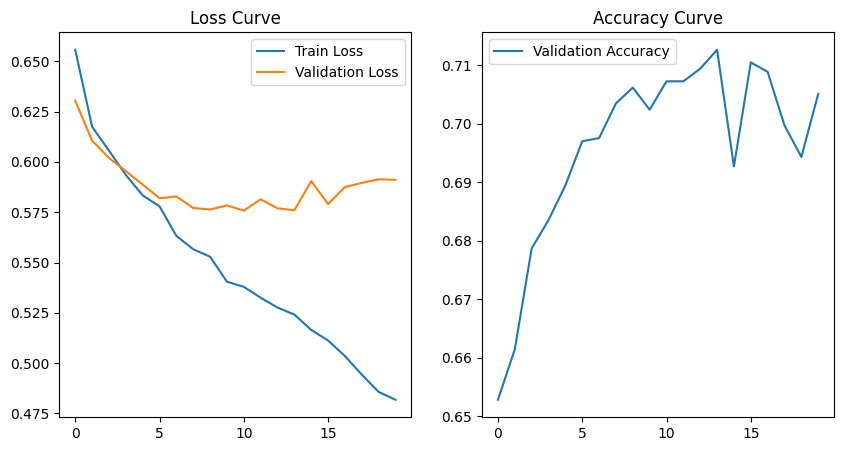

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()
